[kaggle](https://www.kaggle.com/competitions/eso-battery-forecasting)
# Summary
## Goal

To predict battery behaviour on Great Britain's electricity network. 

Identify trends, detect anomalies, and develop predictive models to balance the system.

    - Start with Solar.
    - Then work your way to Wind and other stuff.

## Editor's Notes

### Iteration 2.
    sheffield solar.
    relation to batteries.
    the way I see it, we have main sources of energy.
    Solar and Wind.
    These generate electicity in certain periods of time.
    Then we have the population of a particular area.
    that uses the energy in a predictable manner too.
    The battery re-charges when 
        there is excess energy generated and 
        when demand is low.
    Battery dis-charges when
        energy generated from sources is low
        when demand is high.
    Zero is the baseline.
    When the battery output is positive then it is discharging.
    When battery output is negative then it is recharging from excess energy.
    
    Q: Why do you need to know how much energy is generated by solar?
    
    If I know how much energy is generated, then I would know when there is excess energy and when there is low energy.
    From what I know the Solar peaks at 1200.
    Therefore, the battery is most likely charging that excess energy.
    And the battery output would be negative.
    I know also know that the energy demand is highest at around 10am when people are at work and 10pm when they go back home.
    So, battery output would be positive because it is discharging energy because Solar Energy is generating lower energy output during that time.
    
    Price would be high during the time when energy is demand.
    This would be a good indicator of demand too.
    
    









































### Iteration 1.
I have added the average by the hour to see the score.
Also, for splitting train|test, I went with using the 2 years worth
of data namely, from 2020-08-01 to 2022-08-31, as my training date.
And the rest are test data.
I did not do any validation yet.
I need to understand first how a battery works in a grid.
I know that the cities must be using it only when there is
no wind, solar and other renewables generating power.
From the averages, I see that the batteries are being charged during early morning.
Then they are being used heavily at night, just before 2000 utc.

What would be interesting is to see how wind|solar are generating energy
and how the prices affects usage.


### Iteration 0.

The data seems to be organized by cities
and there is an overarching metric, which is the target - battery_output.
What I understand, battery output is positive when it is recharging
and it is negative when it is discharging.
I need to graph it out so that I can see it and take it from there.

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns, matplotlib.pyplot as plt
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('/kaggle/input/eso-battery-forecasting/train_data.csv')

In [3]:
df.dtypes.value_counts()

float64    262
object      31
int64        1
dtype: int64

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '')

df['utc_settlement_datetime'] = pd.to_datetime(df['utc_settlement_datetime'])
df['date'] = df['utc_settlement_datetime'].dt.date

num = [x for x in df.columns if df.dtypes[x] == 'float64']
cat = [x for x in df.columns if df.dtypes[x] == 'object']
target = 'battery_output'
num.remove(target)

price = [x for x in num if 'price' in x]
coor = [x for x in num if 'long' in x or 'latitude' in x]
pop = [x for x in num if 'population' in x]
is_ = [x for x in num if 'is_' in x]

date = 'utc_settlement_datetime'
utco = [x for x in num if 'utc' in x]
surf = [x for x in num if 'surface_pressure' in x]
gent = [x for x in num if 'generationtime' in x]

wcode = [x for x in num if 'weathercode' in x]
temp = [x for x in num if 'temperature' in x]
wind = [x for x in num if 'wind' in x]
cloud = [x for x in num if 'cloud' in x]
rain = [x for x in num if 'prec' in x or 'rain' in x]
humid = [x for x in num if 'humid' in x]
snow = [x for x in num if 'snow' in x]
dewp = [x for x in num if 'dewpoint' in x]
elev = [x for x in num if 'elevation' in x]


In [5]:
train = df.loc[df[date].dt.date < pd.Timestamp('2022-09-01').date()]
test = df.loc[df[date].dt.date >= pd.Timestamp('2022-09-01').date()]

# Explore

In [6]:
corr = train.corr(numeric_only=True)

corr[target].sort_values(ascending=False).head()

battery_output                             1.000000
windspeed_100mnewcastleupontyne_weather    0.036603
windgusts_10mnewcastleupontyne_weather     0.036383
windspeed_10mnewcastleupontyne_weather     0.035655
windspeed_100mleeds_weather                0.031763
Name: battery_output, dtype: float64

In [7]:
belfast = [x for x in df.columns if 'belfast' in x]

## Target

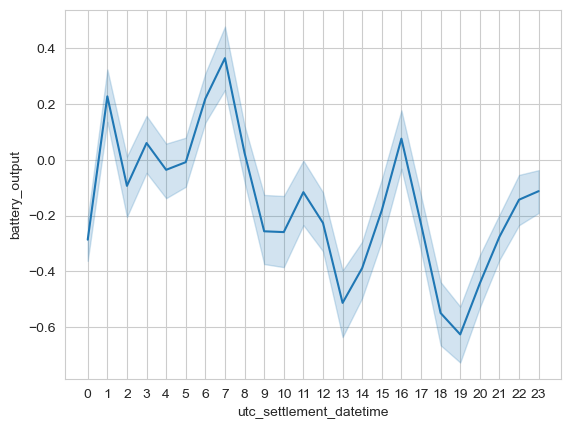

In [24]:
g = train
sns.lineplot(x=train[date].dt.hour, y=target, data=g)
plt.xticks(range(0,24));

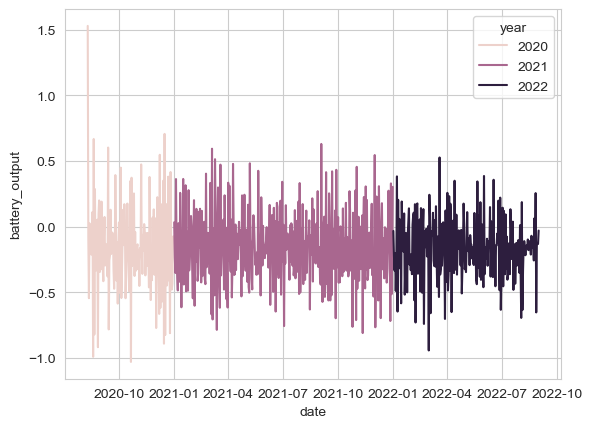

In [9]:
g = train
g = g.groupby([g[date].dt.date, g[date].dt.year])[[target]].mean()
g = g.reset_index(names=['date', 'year'])
sns.lineplot(x='date', y='battery_output', hue='year', data=g);

In [10]:
g

,date,year,battery_output
0,2020-08-10,2020,1.528000
1,2020-08-11,2020,-0.092125
2,2020-08-12,2020,-0.544292
3,2020-08-13,2020,0.025042
4,2020-08-14,2020,-0.127583
...,...,...,...
747,2022-08-27,2022,-0.652500
748,2022-08-28,2022,-0.142875
749,2022-08-29,2022,-0.123750
750,2022-08-30,2022,-0.131000


## Check

In [11]:
check = train.loc[train[date].dt.date == pd.to_datetime('2020-09-11').date()]

In [20]:
check.head().T

,1489,1490,1491,1492,1493
id,1489,1490,1491,1492,1493
utc_settlement_datetime,2020-09-11 00:00:00,2020-09-11 00:30:00,2020-09-11 01:00:00,2020-09-11 01:30:00,2020-09-11 02:00:00
battery_output,-1.484,-1.164,-0.482,-2.28,-2.32
east_midlands_price,7.56,7.56,7.56,7.14,7.56
eastern_england_price,7.938,7.938,7.938,7.497,7.938
london_price,7.56,7.56,7.56,7.14,7.56
merseyside_and_northern_wales_price,8.316,8.316,8.316,7.854,8.316
north_western_england_price,7.938,7.938,7.938,7.497,7.938
northern_scotland_price,9.072,9.072,9.072,8.568,9.072
south_western_england_price,8.694,8.694,8.694,8.211,8.694


In [27]:
is_

['is_daybelfast_weather',
 'is_daybirmingham_weather',
 'is_dayglasgow_weather',
 'is_dayleeds_weather',
 'is_dayliverpool_weather',
 'is_daylondon_weather',
 'is_daymanchester_weather',
 'is_daynewcastleupontyne_weather',
 'is_daysheffield_weather',
 'is_daysouthhampton-portsmouth_weather']

In [30]:
check[[date, target, 'generationtime_mssheffield_weather']]

,utc_settlement_datetime,battery_output,generationtime_mssheffield_weather,is_daybelfast_weather,is_daybirmingham_weather,is_dayglasgow_weather,is_dayleeds_weather,is_dayliverpool_weather,is_daylondon_weather,is_daymanchester_weather,is_daynewcastleupontyne_weather,is_daysheffield_weather,is_daysouthhampton-portsmouth_weather
1489,2020-09-11 00:00:00,-1.484,453.242898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1490,2020-09-11 00:30:00,-1.164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1491,2020-09-11 01:00:00,-0.482,453.242898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1492,2020-09-11 01:30:00,-2.280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1493,2020-09-11 02:00:00,-2.320,453.242898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1494,2020-09-11 02:30:00,-1.268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1495,2020-09-11 03:00:00,0.160,453.242898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,2020-09-11 03:30:00,0.446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1497,2020-09-11 04:00:00,-0.240,453.242898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1498,2020-09-11 04:30:00,-0.130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Pipeline

In [13]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attributes]

num_pp = Pipeline([
    ('dataselect', DataSelect(num))
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(cat))
    , ('encoder', OneHotEncoder(sparse_output=False))
])

pipe = FeatureUnion([
    ('num', num_pp)
    , ('cat', cat_pp)
])

pipe.fit(train)
train_pre = pipe.transform(train)
# test_pre = pipe.transform(test)

# Submission

In [14]:
samp = pd.read_csv('/kaggle/input/eso-battery-forecasting/test_data.csv')

pred = pd.to_datetime(samp['UTC_Settlement_DateTime']).dt.hour.map(train.groupby(train[date].dt.hour)[target].mean())

pd.DataFrame({
    'id': samp['id']
    , 'battery_output': pred
}).to_csv('submission.csv', index=False)